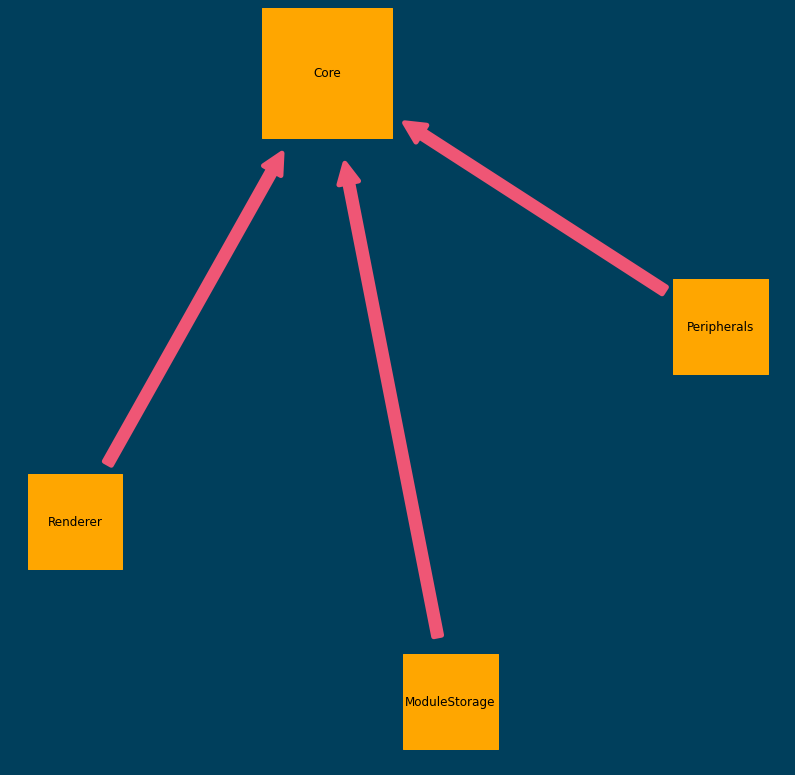

In [2]:
import clang.cindex
import os
from pprint import pprint

if not clang.cindex.Config.loaded:
    clang.cindex.Config.set_library_file('/usr/lib/x86_64-linux-gnu/libclang-11.so.1')

def GetModuleDependencies(path):
    index = clang.cindex.Index.create()
    compdb = clang.cindex.CompilationDatabase.fromDirectory('build/')
    commands = compdb.getCompileCommands(path)

    file_args = []
    for command in commands:
        for argument in command.arguments:
            file_args.append(argument)
    file_args = file_args[:-1]

    translation_unit = index.parse(path, file_args)

    modules = []
    for it in translation_unit.get_includes():
        if it.depth <= 1:
            modules.append(it.include.name)
    return modules

def FindModuleDependencies():
    dependency_mappings = {}
    for dir in os.listdir("Modules"):
        
        manifest_path = os.path.join('Modules', dir, 'OutOfModule.hpp')
        
        if os.path.exists(manifest_path):
            dependency_mappings[dir] = GetModuleDependencies(manifest_path)
    return dependency_mappings

module_pairings = FindModuleDependencies()

edges = []
for child in module_pairings:
    parents = module_pairings[child]
    
    parents = [os.path.split(x)[1].split('.')[0] for x in parents]
    
    for parent in parents:
        edges.append((child, parent))

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from networkx.drawing.nx_pydot import graphviz_layout

PRIMARY_COLOR = '#003f5c'
SECONDARY_COLOR = '#7a5195'
TERTIARY_COLOR = '#ef5675'
TERNARY_COLOR = '#ffa600'

plt.rcParams["figure.figsize"] = [14,14]
fig, ax = plt.subplots()

G = nx.DiGraph()
G.add_edges_from(edges)

d = dict(G.degree)
pos = graphviz_layout(G, prog="twopi")
#pos = graphviz_layout(G, prog="dot")
nx.draw(
    G, 
    node_size=[5000 + v * 4000 for v in d.values()], 
    node_shape = 's', 
    node_color = TERNARY_COLOR,
    with_labels=True,
    arrowsize=40,
    arrowstyle='simple',
    edge_color = TERTIARY_COLOR,
    width=5)
    
ax.set_facecolor(PRIMARY_COLOR)
ax.axis('off')
fig.set_facecolor(PRIMARY_COLOR)
plt.show()
